In [88]:
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Research import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
import numpy as np
from pykalman import KalmanFilter

# Create an instance
qb = QuantBook()

s1 = qb.AddEquity("v")
s2 = qb.AddEquity("ma") # https://www.pairtradinglab.com/backtests/YBZ9FuMn7s1eaibU
start_date = datetime(2019,1,1)
end_date = datetime(2021,1,1)
hedge_lookback = 21
dist = 253
entry = 1.5
zstop = 4.0

In [89]:
def get_spreads(series1, series2, length):
    residuals = []
    zscores = []
    
    for i in range(1, hedge_lookback):
        start_index = len(series1) - length - hedge_lookback + i
        hedge, intercept = linreg(series2[start_index-hedge_lookback:start_index], 
                                  series1[start_index-hedge_lookback:start_index])
        residuals = np.append(residuals, series1[i] - hedge*series2[i] + intercept)

    for i in range(length):
        start_index = len(series1) - length + i
        hedge, intercept = linreg(series2[start_index-hedge_lookback:start_index], 
                                  series1[start_index-hedge_lookback:start_index])
        current_residual = series1[i] - hedge*series2[i] + intercept
        residuals = np.append(residuals, current_residual)
        avg = np.mean(residuals[-hedge_lookback:])
        std = np.std(residuals[-hedge_lookback:])
        zscores = np.append(zscores, (current_residual-avg)/std)
    return zscores, residuals
    
def linreg(series1, series2):
    slope, intercept, rvalue, pvalue, stderr = linregress(series1,series2)
    return slope, intercept

def halflife(series): 
    lag = np.roll(series, 1)
    ret = series - lag
    slope, intercept = linreg(lag,ret)
    halflife = (-np.log(2) / slope)
    return halflife

def alpha(series1, series2):
    slope, intercept = linreg(series2, series1)
    y_target_shares = 1
    X_target_shares = -slope
    notionalDol =  abs(y_target_shares * series1[-1]) + abs(X_target_shares * series2[-1])
    (y_target_pct, x_target_pct) = (y_target_shares * series1[-1] / notionalDol, X_target_shares * series2[-1] / notionalDol)
    if (min (abs(x_target_pct), abs(y_target_pct)) > MIN_WEIGHT):
        return slope
    return float('NaN')

def run_kalman(series):
    kf_stock = KalmanFilter(transition_matrices = [1], observation_matrices = [1],
                            initial_state_mean = series[0], 
                            observation_covariance=0.001,
                            transition_covariance=0.0001)
    filtered_series = kf_stock.smooth(series)[0].flatten()
    return filtered_series

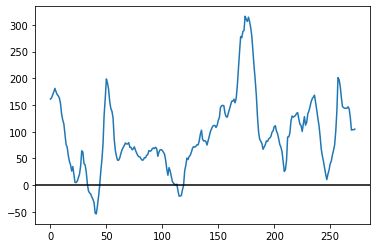

In [97]:
series1 = qb.History(s1.Symbol, start_date, end_date, Resolution.Daily).close.values.tolist()
series2 = qb.History(s2.Symbol, start_date, end_date, Resolution.Daily).close.values.tolist()
spreads, residuals = get_spreads(series1,series2,dist)
plt.plot(residuals)
plt.axhline(y=0, color='k')

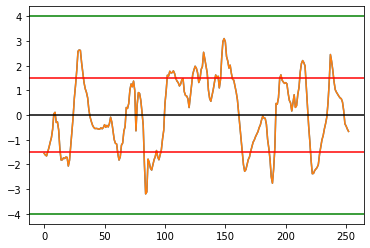

In [91]:
plt.plot(spreads)
plt.plot(spreads)
plt.axhline(y=entry, color='r')
plt.axhline(y=-entry, color='r')
plt.axhline(y=0, color='k')
plt.axhline(y=zstop, color='g')
plt.axhline(y=-zstop, color='g')